<a href="https://colab.research.google.com/github/Abhinandan-Pal/FUSION_VAE/blob/master/Fusion_VAE_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [0]:
import tensorflow as tf
#from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from IPython import display

In [4]:
from google.colab import files
files.upload()
#get the file to be uploded from Account -> create new API token on your kaggle page


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhinandanpal","key":"a0987a8e0f0dcb1ae628a9de5b02e69f"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.32G/1.33G [00:22<00:00, 63.7MB/s]
100% 1.33G/1.33G [00:23<00:00, 61.9MB/s]


In [7]:
from zipfile import ZipFile
file_name = "celeba-dataset.zip"

with ZipFile(file_name,'r') as zip1:
  zip1.extractall()
  print('Done')

Done


In [0]:
import math
BATCH_SIZE = 100
IMG_HEIGHT = 128
IMG_WIDTH = 128

In [9]:

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_data_gen = image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory='/content/img_align_celeba',
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           )


Found 202599 images belonging to 1 classes.


In [10]:
BATCHES_PER_EPOCH =(int)(202599/100)
BATCHES_PER_EPOCH

2025

In [0]:
FACE_RATIO = 0.5

In [0]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(128, 128, 3)),
          tf.keras.layers.Conv2D(
              filters=96, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Conv2D(
              filters=256, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Conv2D(
              filters=384, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Conv2D(
              filters=256, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=8*8*256, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(8, 8, 256)),
          tf.keras.layers.Conv2DTranspose(
              filters=384,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
         tf.keras.layers.Conv2DTranspose(
              filters=384,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
         tf.keras.layers.Conv2DTranspose(
              filters=256,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          tf.keras.layers.Conv2DTranspose(
              filters=96,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=3, kernel_size=3, strides=(1, 1), padding="SAME"),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits
  def twoFace(self,x1,x2):
     mean1, logvar1 = tf.split(self.inference_net(x1), num_or_size_splits=2, axis=1)
     mean2, logvar2 = tf.split(self.inference_net(x2), num_or_size_splits=2, axis=1)
     mean1 = tf.squeeze(mean1)
     mean2 = tf.squeeze(mean2)
     logvar1 = tf.squeeze(logvar1)
     logvar2 = tf.squeeze(logvar2)
     meanF = []
     logvarF = []
     print(logvar2 .shape)
     for i in range(len(mean1)):
       if(random.random()<FACE_RATIO):
         meanF.append(mean1[i])
         logvarF.append(logvar1[i])
       else:
         meanF.append(mean2[i])
         logvarF.append(logvar2[i])
     meanF = tf.convert_to_tensor(meanF, dtype=tf.float32)
     meanF  = tf.expand_dims(meanF, 0)

     logvarF = tf.convert_to_tensor(logvarF, dtype=tf.float32)
     logvarF  = tf.expand_dims(logvarF, 0)
     print(logvarF.shape)
     return meanF, logvarF





In [0]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [0]:
latent_dim = 256

In [0]:
epochs = 2

num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])

# NEW MODEL

In [0]:
model = CVAE(latent_dim)

# LOAD MODEL

In [0]:
model = CVAE(latent_dim)
model.generative_net.load_weights("generative_m.hdf5")
model.inference_net.load_weights("inference_m.hdf5")

# TRAIN & EXECUTE

In [0]:
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for i in range (2010):
    # MAX Possibility 2025
    train_x = train_data_gen[i][0]
    display.clear_output(wait=False)
    print('Epoch: {}, Batch: {}, '.format(epoch,i))
    compute_apply_gradients(model, train_x, optimizer)
  end_time = time.time()

  if epoch % 1 == 0:
    model.generative_net.save_weights("generative_m.hdf5")
    model.inference_net.save_weights("inference_m.hdf5")
    loss = tf.keras.metrics.Mean()
    for i in range(2010,2020):
      test_x = train_data_gen[i][0]
      loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))

In [0]:
model.generative_net.save_weights("generative_m.hdf5")
model.inference_net.save_weights("inference_m.hdf5")

In [0]:
def child_image_gen():
    a1 = random.randint(1,100)
    a2 = random.randint(1,100)
    b1 = random.randint(1,2000)
    b2 = random.randint(1,2000)

    x1 = train_data_gen[b1][0][a1]
    x2 = train_data_gen[b2][0][a2]
  
    x1  = tf.expand_dims(x1, 0)
    x2 = tf.expand_dims(x2, 0)

    mean, logvar = model.twoFace(x1,x2)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z,apply_sigmoid=True)
    x_logit = tf.squeeze(x_logit)

    x1 = tf.squeeze(x1)
    x2 = tf.squeeze(x2)
    fig = plt.figure(figsize=(1,3),dpi=640)
    plt.subplot(1,3, 1)

    plt.imshow(x1, cmap='gray')
    plt.axis('off')
    plt.subplot(1,3 ,2)

    plt.imshow(x2, cmap='gray')
    plt.axis('off')
    plt.subplot(1,3, 3)
    
    plt.imshow(x_logit, cmap='gray')
    plt.title("CHILD")
    plt.axis('off')
    plt.savefig('test.png')
  

(256,)
(1, 256)


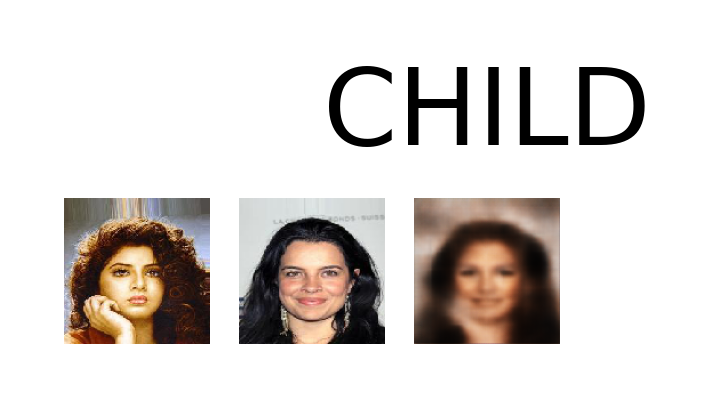

In [37]:
child_image_gen()